<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/04_story_mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install acoustics

In [2]:
#!pip install latex

In [3]:
import scipy.io
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import InputLayer
from tensorflow import keras

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/22_Realistic_pipe_ML/input/'

In [7]:
mode = 'Timelapse'
#mode = 'Instant'
autoencoder_save = True
autoencoder_load = False

In [8]:
#clock positions
mat = scipy.io.loadmat(path + 'trace_pos_clock_v7_rot_overlap.mat')
X = mat['trace_pos_clock'].astype('float32')

In [9]:
#cm positions
#mat = scipy.io.loadmat(path + 'trace_pos_cm_v7_rot.mat')
#X = mat['trace_pos_cm']

In [10]:
X = np.swapaxes(X, 2, 1)
X.dtype

dtype('float32')

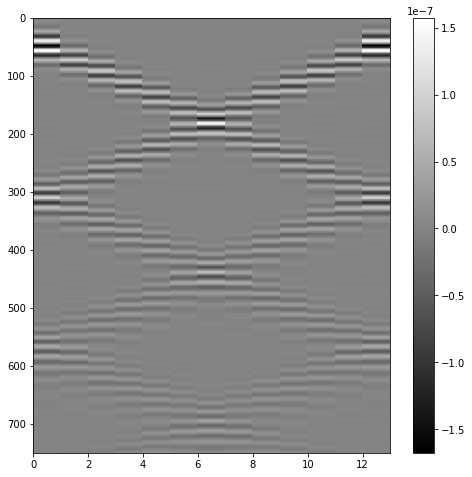

In [11]:
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [12]:
X.shape[-1]

750

In [13]:
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 750)

In [14]:
time_scaling.dtype

dtype('float32')

In [15]:
X = np.multiply(X, time_scaling)

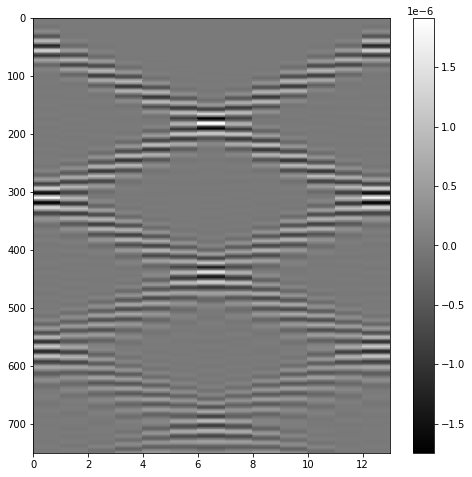

In [16]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [17]:
labels = pd.read_csv(path + 'labels.csv')

In [18]:
labels

,modelname,thickness,seed,depression,pitting,depression_mu,depression_sigma,thickness_max,thickness_min,thickness_mean,thickness_median,thickness_std,thickness_var
0,model_t032_s101_d000_p002,32,101,0,2,1756.336829,278.267035,32,30,31.046875,31.0,0.725872,0.526890
1,model_t032_s101_d000_p004,32,101,0,4,1756.336829,278.267035,32,28,30.436343,31.0,1.152609,1.328508
2,model_t032_s101_d000_p006,32,101,0,6,1756.336829,278.267035,32,26,30.138310,30.0,1.457739,2.125004
3,model_t032_s101_d000_p008,32,101,0,8,1756.336829,278.267035,32,24,30.029514,30.0,1.624967,2.640518
4,model_t032_s101_d000_p010,32,101,0,10,1756.336829,278.267035,32,22,29.994792,30.0,1.699060,2.886804
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,model_t040_s116_d024_p002,40,116,24,2,1512.291398,189.482963,40,14,35.737847,39.0,6.787417,46.069027
2796,model_t040_s116_d024_p004,40,116,24,4,1512.291398,189.482963,40,12,35.088831,38.0,6.839524,46.779082
2797,model_t040_s116_d024_p006,40,116,24,6,1512.291398,189.482963,40,10,34.801505,38.0,6.913646,47.798504
2798,model_t040_s116_d024_p008,40,116,24,8,1512.291398,189.482963,40,10,34.721065,38.0,6.935825,48.105675


In [19]:
labels.rename(columns={'depression':'depression depth', 
                       'pitting':'pitting depth', 
                       'depression_mu':'depression location',
                       'depression_sigma':'depression width',
                       'thickness_max':'thickness maximum',
                       'thickness_min':'thickness minimum', 
                       'thickness_mean':'thickness mean',
                       'thickness_median':'thickness median',
                       'thickness_std':'thickness std'}, inplace=True)

In [20]:
#temp_s102_t040 = labels[(labels['seed']==102) & (labels['thickness']==40)]

In [21]:
#temp_s102_t040

In [22]:
from acoustics import generator
def make_noise(noisedb, noiseshape):
  noise = np.zeros(noiseshape, dtype='float32')
  noiselev = 10**(noisedb/10)
  for i in range(noiseshape[0]):
    for j in range(noiseshape[1]):
      noise[i, j, :] = generator.noise(noiseshape[2], color='pink')*noiselev





  return noise

In [23]:
X.dtype

dtype('float32')

In [24]:
#testnoise = make_noise(-20, (10, 11, 640))
#testnoise.dtype

In [25]:
#plt.pcolormesh(testnoise[1, :, :].T)
#plt.colorbar()
#plt.show()

# Story mode

In [26]:
def make_sample(labels, s, thickness, num_traces=10):
  df = labels[(labels['seed']==s) & (labels['thickness']==thickness)]
  #s = 102
  #thickness = 40
  #num_traces = 10
  dep_inc = 4
  pit_inc = 2
  random_picks = pd.DataFrame(columns=df.columns)
  random_picks = random_picks.append(df.iloc[0])
  while len(random_picks) < num_traces:
    last_depression = random_picks.iloc[-1]['depression depth']
    last_pitting = random_picks.iloc[-1]['pitting depth']
    development = np.random.choice(['quo', 'pit_increase', 'dep_increase'], p=[0.5, 0.2, 0.3])
    #print(development)
    if development == 'dep_increase':
      new_dep = last_depression + dep_inc
      new_pit = last_pitting
    elif development == 'pit_increase':
      new_pit = last_pitting + pit_inc
      new_dep = last_depression
    elif development == 'quo':
      new_pit = last_pitting
      new_dep = last_depression
  
    row = df[(df['depression depth'] == new_dep) & (df['pitting depth'] == new_pit) ]
    random_picks = random_picks.append(row)
  return random_picks

In [27]:
def make_samples(X, df, num_samples):
  
  labels_samples = pd.DataFrame(columns=df.columns)
  X_list_c = []
  X_list_n = []
  for i in range(num_samples):
    s = np.random.choice(df['seed'].unique())
    thickness = np.random.choice(df['thickness'].unique())
    #print(s, thickness)
    df_temp = make_sample(labels=df, s=s, thickness=thickness, num_traces=10)
    X_temp = X[df_temp.index, :,:640]/X.max()
    #add noise###################################################################
    #print(X_temp.shape)
    X_list_c.append(X_temp)
    X_list_n.append(X_temp + make_noise(-20, X_temp.shape))
    #X_list.append(X[df_temp.index, :640,:]/X.max())
    #print(df_temp['modelname'])
    labels_samples = labels_samples.append(df_temp.iloc[-1:])


                          
  return np.stack(X_list_c), np.stack(X_list_n), labels_samples.reset_index()


In [28]:
if mode=='Timelapse':
  X_sample_c, X_sample_n, label_sample = make_samples(X, labels, 2800)

# Instant Mode

In [29]:

if mode=='Instant':
  X_sample_c = X[:,:,:640]/X.max()
  X_sample_n = X_sample_c + make_noise(-20, X_sample_c.shape)
  label_sample = labels

  X_sample_n = np.expand_dims(X_sample_n, 1)
  X_sample_c = np.expand_dims(X_sample_c, 1)

In [30]:
X_sample_n.shape

(2800, 10, 13, 640)

In [31]:
#np.prod(X_sample.shape)

In [32]:
#X_sample.shape, label_sample.shape

In [33]:
X.max()

1.9439242e-06

# Subselecting Data

In [34]:
# Only last acquisition kept:
X_sample_n = X_sample_n[:,-1,:,:]
X_sample_c = X_sample_c[:,-1,:,:]

X_sample_n = np.expand_dims(X_sample_n, 1)
X_sample_c = np.expand_dims(X_sample_c, 1)

X_sample_n.shape, X_sample_c.shape


((2800, 1, 13, 640), (2800, 1, 13, 640))

In [35]:
sensorindex = [0, 12]
# Sparse sensor mode:
#X_sample_n = X_sample_n[:,:,3:10:3,:] # 3 channels kept
#X_sample_c = X_sample_c[:,:,3:10:3,:]
X_sample_n = np.take(X_sample_n, sensorindex, axis=2)
X_sample_c = np.take(X_sample_c, sensorindex, axis=2)


In [36]:
# Single sensor mode
'''X_sample_n = X_sample_n[:,:,5,:]
X_sample_c = X_sample_c[:,:,5,:]

X_sample_n = np.expand_dims(X_sample_n, 2)
X_sample_c = np.expand_dims(X_sample_c, 2)
'''

'X_sample_n = X_sample_n[:,:,5,:]\nX_sample_c = X_sample_c[:,:,5,:]\n\nX_sample_n = np.expand_dims(X_sample_n, 2)\nX_sample_c = np.expand_dims(X_sample_c, 2)\n'

In [37]:
X_sample_n.shape, X_sample_c.shape

((2800, 1, 2, 640), (2800, 1, 2, 640))

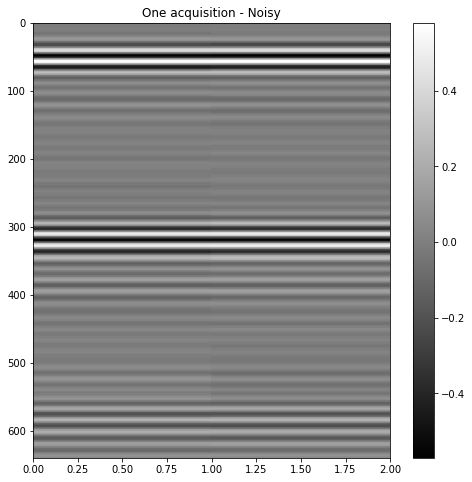

In [38]:
plt.figure(figsize=(8,8))

plt.pcolormesh(X_sample_n[1, 0,:, :].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('One acquisition - Noisy')


plt.show()

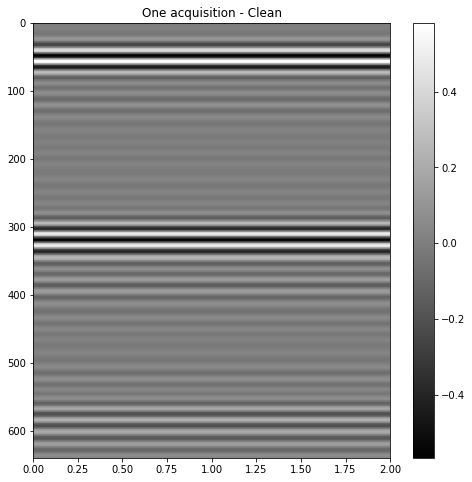

In [39]:
plt.figure(figsize=(8,8))

plt.pcolormesh(X_sample_c[1, 0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.title('One acquisition - Clean')

plt.show()

# Label attributes

In [40]:
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

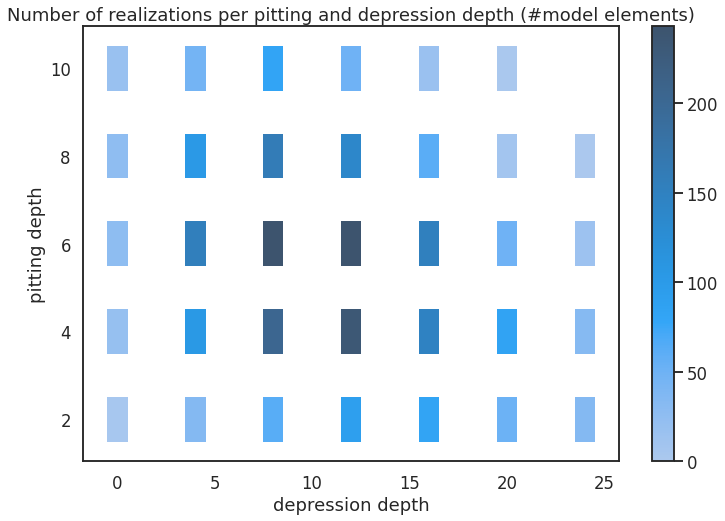

In [41]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="depression depth", y="pitting depth", discrete=True, cbar=True)
#sns.histplot(data=label_sample, x="pitting", binwidth=1)
plt.title('Number of realizations per pitting and depression depth (#model elements)')
plt.show()

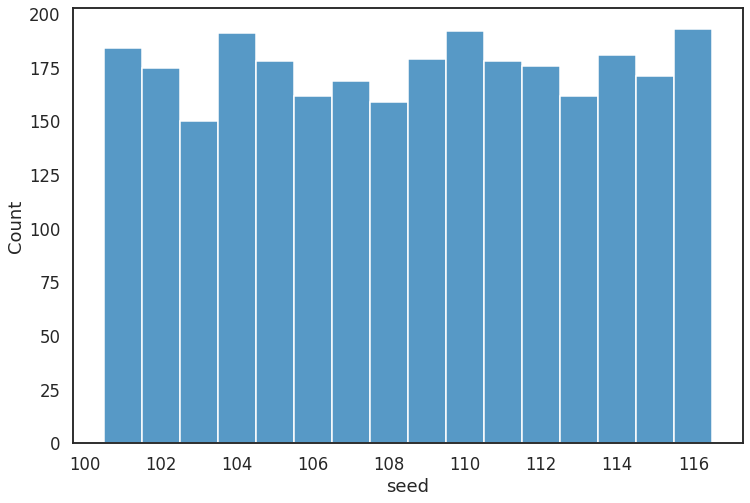

In [42]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="seed", discrete=True)

plt.show()

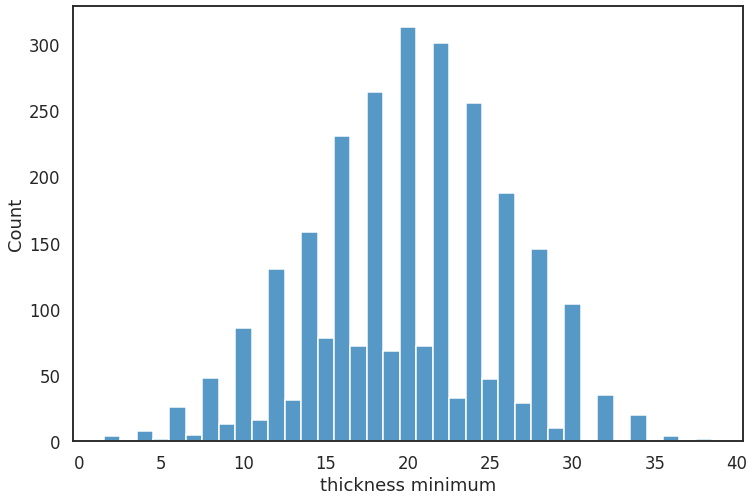

In [43]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="thickness minimum", discrete=True)

plt.show()

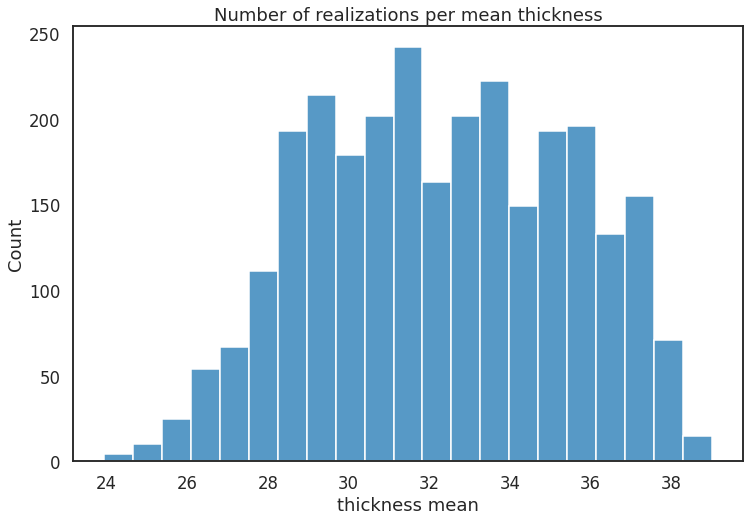

In [44]:
plt.figure(figsize=(12,8))
sns.histplot(data=label_sample, x="thickness mean")
plt.title("Number of realizations per mean thickness")
plt.show()

In [45]:
#stop

In [46]:
X_sample_c.shape, label_sample.shape

((2800, 1, 2, 640), (2800, 14))

# ML

In [47]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n, X_sample_c, test_size=0.2, random_state=42)

In [48]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train_flat = y_train.reshape((len(y_train), np.prod(y_train.shape[1:])))
y_test_flat = y_test.reshape((len(y_test), np.prod(y_test.shape[1:])))

In [49]:
y_train.shape, y_test.shape

((2240, 1, 2, 640), (560, 1, 2, 640))

In [50]:
x_train_flat.shape[1], x_test_flat.shape

(1280, (560, 1280))

In [51]:
import keras
from keras import layers
from keras import regularizers
from keras.utils.vis_utils import plot_model
from keras.models import load_model

In [52]:
def make_autoencoder_ss(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(512, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(256, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(128, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)

  


  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(128, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(256, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(512, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-4](encoded_input)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

In [53]:
def make_autoencoder(encoding_dim=64):

  input_trace = keras.Input(shape=(x_train_flat.shape[1],))
  # Add a Dense layer with a L1 activity regularizer
  encoded = layers.Dense(1024, activation='tanh')(input_trace)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(512, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(256, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(128, activation='tanh')(encoded)
  #encoded = layers.Dropout(0.2)(encoded)
  encoded = layers.Dense(encoding_dim, activation='tanh')(encoded)

  


  # "decoded" is the lossy reconstruction of the input
  decoded = layers.Dense(128, activation='tanh')(encoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(256, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(512, activation='tanh')(decoded)
  #decoded = layers.Dropout(0.2)(decoded)
  decoded = layers.Dense(1024, activation='tanh')(decoded)
  decoded = layers.Dense(x_train_flat.shape[1], activation='linear')(decoded)

  # This model maps an input to its reconstruction
  autoencoder = keras.Model(input_trace, decoded)

  # This model maps an input to its encoded representation
  encoder = keras.Model(input_trace, encoded)

  # This is our encoded input
  encoded_input = keras.Input(shape=(encoding_dim,))
  deco = autoencoder.layers[-5](encoded_input)
  deco = autoencoder.layers[-4](deco)
  deco = autoencoder.layers[-3](deco)
  deco = autoencoder.layers[-2](deco)
  deco = autoencoder.layers[-1](deco)
  # create the decoder model
  decoder = keras.Model(encoded_input, deco)

  return autoencoder, encoder, decoder

Epoch 1/100
9/9 [==============================] - 1s 31ms/step - loss: 0.0225 - val_loss: 0.0064
Epoch 2/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 3/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 4/100
9/9 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 9.8001e-04
Epoch 8/100
9/9 [==============================] - 0s 13ms/step - loss: 9.4888e-04 - val_loss: 8.6364e-04
Epoch 9/100
9/9 [==============================] - 0s 14ms/step - loss: 8.1574e-04 - val_loss: 7.1626e-04
Epoch 10/100
9/9 [==============================] - 0s 12ms/step - loss: 6.9035e-04 - val_loss: 6.

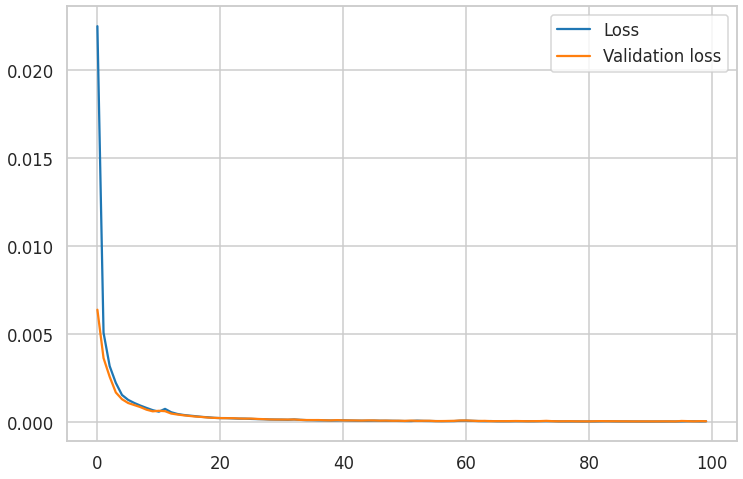

In [54]:
encoding_dim = 64
if autoencoder_load:
  autoencoder = load_model(path + 'autoencoder.h5')
  encoder = load_model(path + 'encoder.h5')
  decoder = load_model(path + 'decoder.h5')
else:
  #autoencoder, encoder, decoder = make_autoencoder_ss(encoding_dim=encoding_dim) #single sensor autoencoder
  autoencoder, encoder, decoder = make_autoencoder(encoding_dim=encoding_dim)
  autoencoder.compile(optimizer='adam', loss='mse')

  history = autoencoder.fit(x_train_flat, y_train_flat,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat, y_test_flat))
  
  sns.set_style('whitegrid')
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.show()


In [55]:
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler


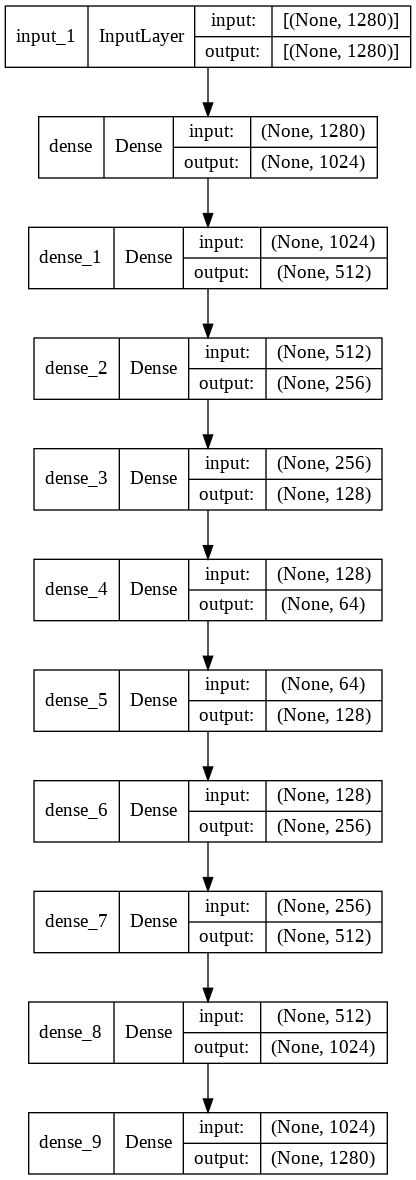

In [56]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

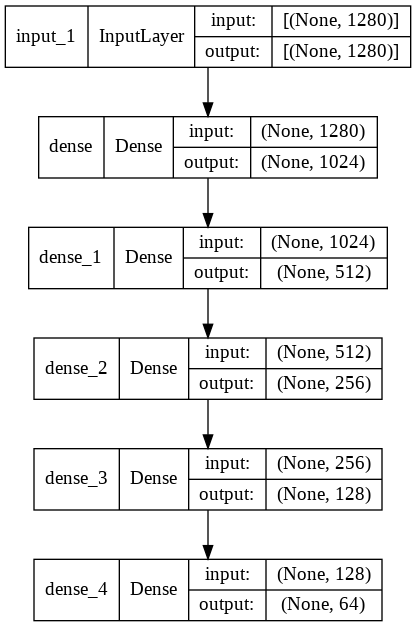

In [57]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

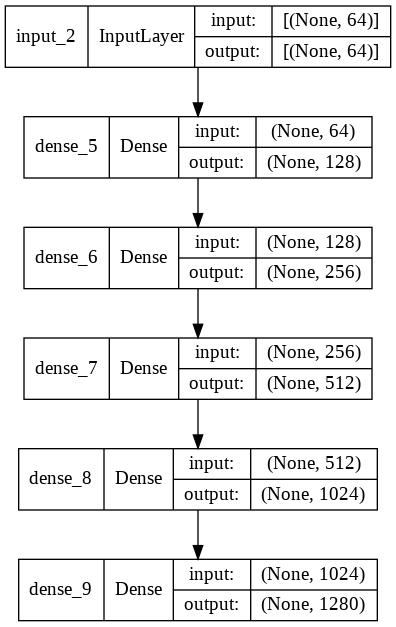

In [58]:
plot_model(decoder, show_shapes=True, show_layer_names=True)

In [59]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1280)]            0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

In [60]:
if autoencoder_save:
  autoencoder.save(path + 'autoencoder.h5')
  encoder.save(path + 'encoder.h5')
  decoder.save(path + 'decoder.h5')

In [61]:
decoded_traces = autoencoder.predict(x_test_flat)
encoded_traces = encoder.predict(x_test_flat)

In [62]:
encoded_traces.shape, decoded_traces.shape

((560, 64), (560, 1280))

In [63]:
y_test.shape

(560, 1, 2, 640)

In [64]:
#test = decoded_traces.reshape(len(decoded_traces), 10, 11, 640)
#test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), 10, 11, 640)
#test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), 1, 11, 640)
#test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), 1, 3, 640)
#test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), 1, 1, 640)
test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), y_test.shape[1], y_test.shape[2], y_test.shape[3]) #Should alway work
#test_decoded_shaped = decoded_traces.reshape(len(decoded_traces), *y_test.shape[1:])

In [65]:
y_test.shape

(560, 1, 2, 640)

In [66]:
x_test.shape, test_decoded_shaped.shape

((560, 1, 2, 640), (560, 1, 2, 640))

In [67]:
#x_test_shaped = x_test.reshape(len(x_test), 10, 11, 640)

In [68]:
#label_sample

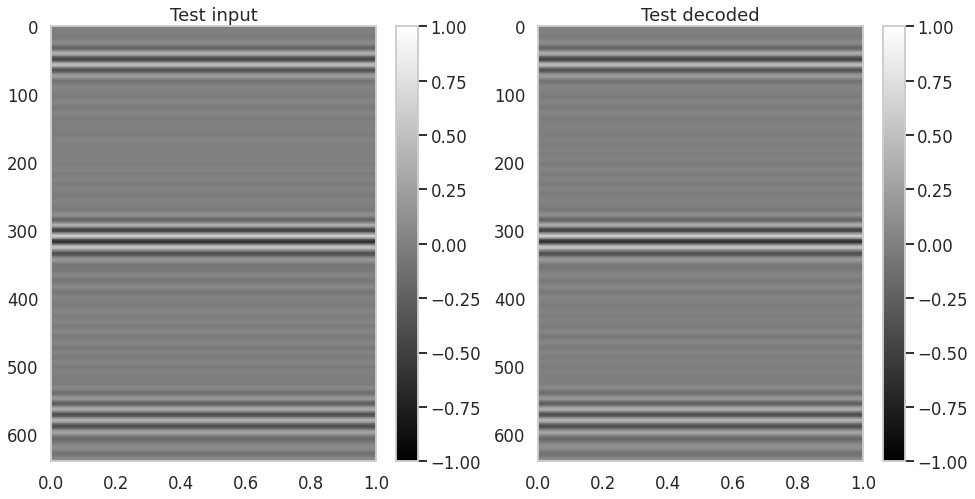

In [69]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_test[1, :,0, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(test_decoded_shaped[1, :,0, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

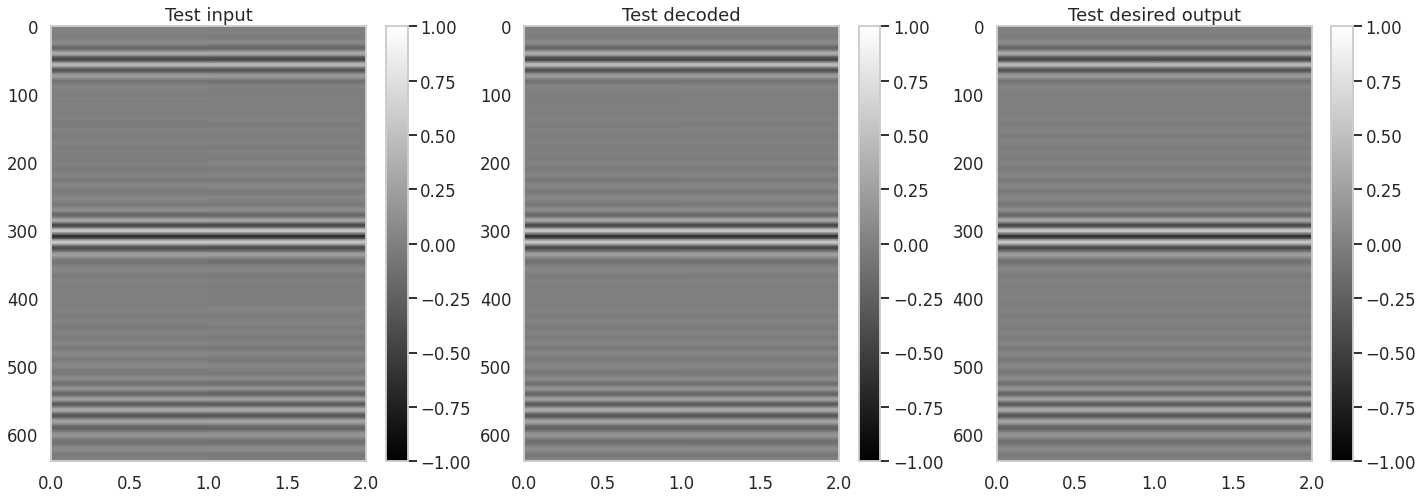

In [70]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(x_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 3, 2)
plt.pcolormesh(test_decoded_shaped[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Test decoded')

plt.subplot(1, 3, 3)
plt.pcolormesh(y_test[0, 0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Test desired output')



plt.show()

In [71]:
x_test.dtype, test_decoded_shaped.dtype, encoded_traces.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [72]:
#np.save(path + 'x_test.npy', x_test)
#np.save(path + 'test_decoded_shaped.npy', test_decoded_shaped)

In [73]:
autoencoder.evaluate(x_test_flat, x_test_flat)

18/18 [==============================] - 0s 2ms/step - loss: 1.5082e-04


0.00015081636956892908

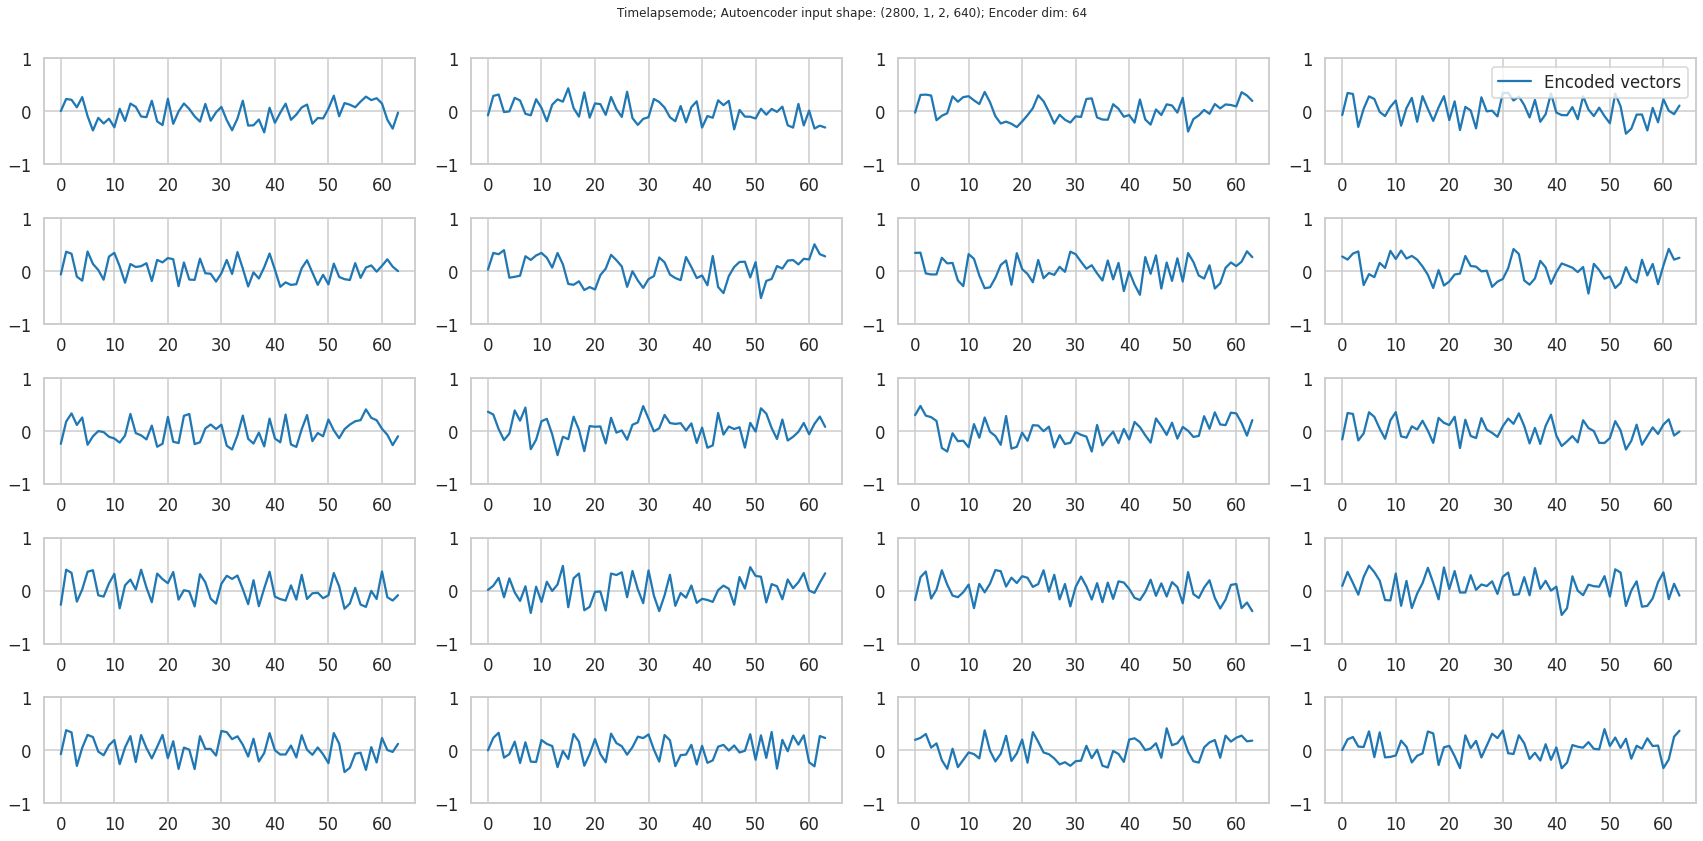

In [74]:
xnum = 5
ynum = 4
n = xnum*ynum

plt.figure(figsize=(24, 12))
for i in range(n):
    ax = plt.subplot(xnum, ynum, i + 1)
    
    #plt.plot(x_test_in[i])
    plt.plot(encoded_traces[i])
    #plt.plot(x_test_in[i])
    if i==ynum-1:
      #plt.legend(['Input trace', 'Decoded trace'], loc=1)
      plt.legend(['Encoded vectors'], loc=1)
    plt.ylim([-1, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(mode+'mode'+'; Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)
plt.show()

# Regression

In [75]:
X_sample_flat = X_sample_n.reshape((len(X_sample_n), np.prod(X_sample_n.shape[1:])))

In [76]:
X_sample_flat.shape

(2800, 1280)

In [77]:
encoded_all = encoder.predict(X_sample_flat)

In [78]:
encoded_all.shape

(2800, 64)

In [79]:
label_sample.columns

Index(['index', 'modelname', 'thickness', 'seed', 'depression depth',
       'pitting depth', 'depression location', 'depression width',
       'thickness maximum', 'thickness minimum', 'thickness mean',
       'thickness median', 'thickness std', 'thickness_var'],
      dtype='object')

In [80]:
#y_reg = label_sample[['thickness_min']]
#y_reg = label_sample[['depression_mu']]
#y_reg = label_sample[['thickness_mean']]
#y_reg = label_sample[['thickness_std']]
#y_reg = label_sample[['depression']]
#y_reg = label_sample[['pitting']]

#attribute = 'thickness_min'
#attribute = 'thickness_mean'
#attribute = 'thickness_std'
#attribute = 'depression'
#attribute = 'depression_mu'
#attribute = 'pitting'
#attributes = ['thickness_mean','thickness_min', 'depression', 'depression_mu','pitting', 'thickness_std']

attributes = ['thickness mean','thickness minimum', 'depression depth', 'depression location','pitting depth', 'thickness std']


In [81]:
label_sample

,index,modelname,thickness,seed,depression depth,pitting depth,depression location,depression width,thickness maximum,thickness minimum,thickness mean,thickness median,thickness std,thickness_var
0,2328,model_t040_s103_d012_p008,40,103,12,8,1610.688163,119.686105,40,21,37.099826,38.0,3.220348,10.370640
1,932,model_t034_s111_d016_p006,34,111,16,6,1921.830063,117.627902,34,12,30.695312,32.0,3.893375,15.158369
2,2575,model_t040_s110_d016_p002,40,110,16,2,1064.549714,313.382153,40,22,35.412326,38.0,5.386305,29.012282
3,786,model_t034_s107_d012_p004,34,107,12,4,1145.154170,351.912351,34,18,29.281250,31.0,4.238157,17.961975
4,2187,model_t038_s115_d012_p006,38,115,12,6,1202.847511,331.109760,38,20,33.263889,35.0,4.276660,18.289822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,1146,model_t036_s101_d020_p004,36,101,20,4,1756.336829,278.267035,36,12,30.448495,33.0,6.498510,42.230632
2796,651,model_t034_s103_d016_p004,34,103,16,4,1610.688163,119.686105,34,14,31.020833,32.0,3.960679,15.686975
2797,1488,model_t036_s111_d012_p008,36,111,12,8,1921.830063,117.627902,36,16,33.023727,34.0,3.150359,9.924762
2798,737,model_t034_s106_d000_p006,34,106,0,6,878.799971,431.722669,34,28,32.154225,32.0,1.438442,2.069117


In [82]:
def make_regression_model():
  model = Sequential()
  model.add(Dense(encoding_dim, activation='tanh'))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(24, activation='tanh'))
  model.add(Dense(16, activation='tanh'))
  model.add(Dense(8, activation='tanh'))
  model.add(Dense(4, activation='tanh'))
  model.add(Dense(1, activation='linear'))
  return model

thickness mean


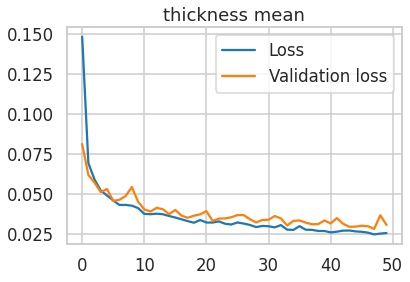

18/18 [==============================] - 0s 2ms/step - loss: 0.0306
loss: 0.03060624934732914
thickness minimum


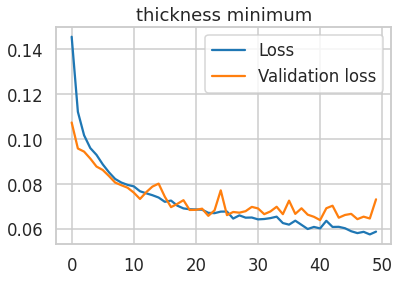

18/18 [==============================] - 0s 2ms/step - loss: 0.0733
loss: 0.07326067984104156
depression depth


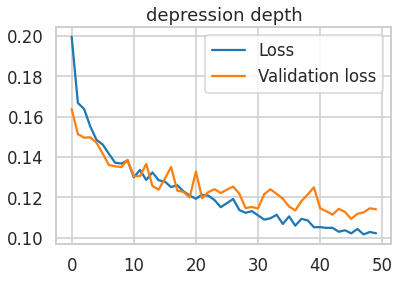

18/18 [==============================] - 0s 2ms/step - loss: 0.1140
loss: 0.11399777233600616
depression location


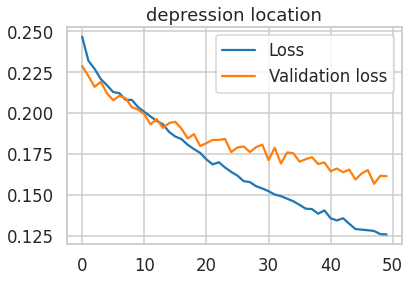

18/18 [==============================] - 0s 2ms/step - loss: 0.1614
loss: 0.16144919395446777
pitting depth


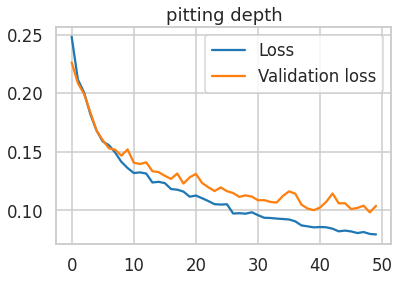

18/18 [==============================] - 0s 2ms/step - loss: 0.1038
loss: 0.10379058122634888
thickness std


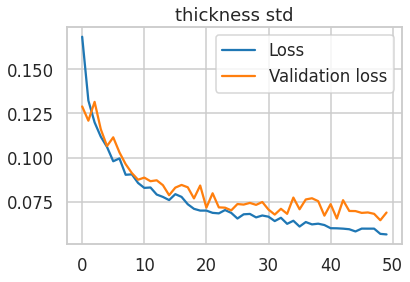

18/18 [==============================] - 0s 2ms/step - loss: 0.0688
loss: 0.06882194429636002


In [83]:
df_loss = pd.DataFrame(columns=attributes)
df_test = pd.DataFrame(columns=attributes)
df_predict = pd.DataFrame(columns=attributes)
for attribute in attributes:
  print(attribute)
  y_reg = label_sample[[attribute]]

  min_max_scaler = MinMaxScaler()
  y_reg = min_max_scaler.fit_transform(y_reg)
  x_reg_train, x_reg_test, y_reg_train, y_reg_test_norm = train_test_split(encoded_all, y_reg, test_size=0.2, random_state=42)
  regression_model = make_regression_model()
  regression_model.compile(loss='mae', optimizer='adam')
  history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                verbose=0,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))
  
  plt.figure(figsize=(6, 4))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Loss', 'Validation loss'])
  plt.title(attribute)
  plt.show()

  y_predict_norm = regression_model.predict(x_reg_test)
  y_predict = min_max_scaler.inverse_transform(y_predict_norm)
  y_reg_test = min_max_scaler.inverse_transform(y_reg_test_norm)
  loss = regression_model.evaluate(x_reg_test, y_reg_test_norm)
  print("loss: " + str(loss))
  df_loss.at[0, attribute] = loss
  df_test[attribute] = np.squeeze(y_reg_test)
  df_predict[attribute] = np.squeeze(y_predict)

In [84]:
df_loss

,thickness mean,thickness minimum,depression depth,depression location,pitting depth,thickness std
0,0.0306062,0.0732607,0.113998,0.161449,0.103791,0.0688219


In [85]:
df_predict

,thickness mean,thickness minimum,depression depth,depression location,pitting depth,thickness std
0,34.001610,20.218090,15.850853,1145.795166,4.271394,5.386168
1,33.666698,19.426271,9.687775,1499.209229,6.753776,4.276389
2,34.208439,22.046162,10.109679,1118.113525,3.908495,2.948361
3,30.411152,17.650690,13.516226,1026.083618,6.295529,3.374816
4,26.913973,12.310781,20.710932,1532.338501,3.399691,6.053330
...,...,...,...,...,...,...
555,31.568441,17.828785,11.062711,1966.890869,5.888131,4.481277
556,31.544510,18.534639,6.159811,1487.432495,9.339371,2.051722
557,29.471861,18.448023,12.877277,1648.513306,5.355179,5.265094
558,29.537977,21.934917,7.364336,1070.452393,5.775863,3.535977


In [86]:
'''history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),
                epochs=50,
                batch_size=20,
                shuffle=True,
                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))
                '''

"history = regression_model.fit(x_reg_train, y_reg_train.astype('float32'),\n                epochs=50,\n                batch_size=20,\n                shuffle=True,\n                validation_data=(x_reg_test, y_reg_test_norm.astype('float32')))\n                "

In [87]:
#plot_model(regression_model, show_shapes=True, show_layer_names=True)

In [88]:
#regression_model.summary()

In [89]:
def plot_pred(fno, title):
  dy = 0.2
  plt.figure(figsize=(8, 8))
  plt.scatter(dy*y_reg_test[:,fno], dy*y_predict[:,fno], alpha=0.3)
  plt.plot([dy*y_reg_test[:,fno].min(), dy*y_reg_test[:,fno].max()], [dy*y_reg_test[:,fno].min(), dy*y_reg_test[:,fno].max()], 'r--' )
  plt.title('Predicted vs true label: ' + title)
  plt.xlabel('True [mm]')
  plt.ylabel('Predicted [mm]')
  plt.grid()
  plt.show()

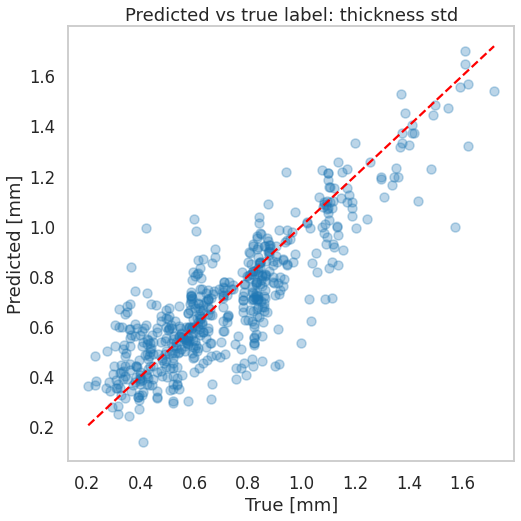

In [90]:
plot_pred(0, attribute)

In [91]:
scales = np.array([[4.5, 8],
                   [-0.5, 8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25],
                   [0, 1.8]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

In [92]:
#import latex

In [93]:
X_sample_n.shape

(2800, 1, 2, 640)

In [94]:
dy = 0.2
def plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True):
  sns.set_style('whitegrid')
  sns.set_context('talk')
  attributes = df_test.columns
  plt.figure(figsize=(14, 17))
  for i, attribute in enumerate(attributes):
    y_test_merge = np.squeeze(np.stack([df_test[[attribute]].to_numpy(), df_predict[[attribute]].to_numpy()]))*dy
    df_test_merge = pd.DataFrame(y_test_merge.T, columns=['True [mm]', 'Predicted [mm]'])
    df_test_merge['abs_diff'] = abs(df_test_merge['True [mm]'] - df_test_merge['Predicted [mm]'])
    df_test_merge.quantile(q=0.75)['abs_diff']        
    df_test_merge['75th percentile'] = np.where(df_test_merge['abs_diff'] < df_test_merge.quantile(q=0.75)['abs_diff'], True, False)
    plt.subplot(3, 2, i+1) 
    if perc:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', hue='75th percentile', alpha=0.5)
      plt.legend(loc='upper left')
    else:
      sns.scatterplot(data=df_test_merge, x='True [mm]', y='Predicted [mm]', alpha=0.5)
    textposx = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.5)
    textposy = 1*(df_scales.at[0, attribute] + (df_scales.at[1, attribute] - df_scales.at[0, attribute])*0.05)
    textstring = "Normalized loss (mae): {:.6f}".format(df_loss.at[0, attribute])
    plt.text(textposx, textposy, textstring, fontsize=11, bbox=dict(facecolor='grey', alpha=0.5))
    plt.plot([df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], [df_test_merge['True [mm]'].min(), df_test_merge['True [mm]'].max()], 'r--')
    plt.title(attribute)
    plt.xlim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    plt.ylim(df_scales.at[0, attribute], df_scales.at[1, attribute])
    
  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  plt.suptitle(mode+'mode'+'; Autoencoder input shape: '+ str(X_sample_n.shape) + '; Encoder dim: ' + str(encoding_dim), fontsize=12)

  plt.show()                           


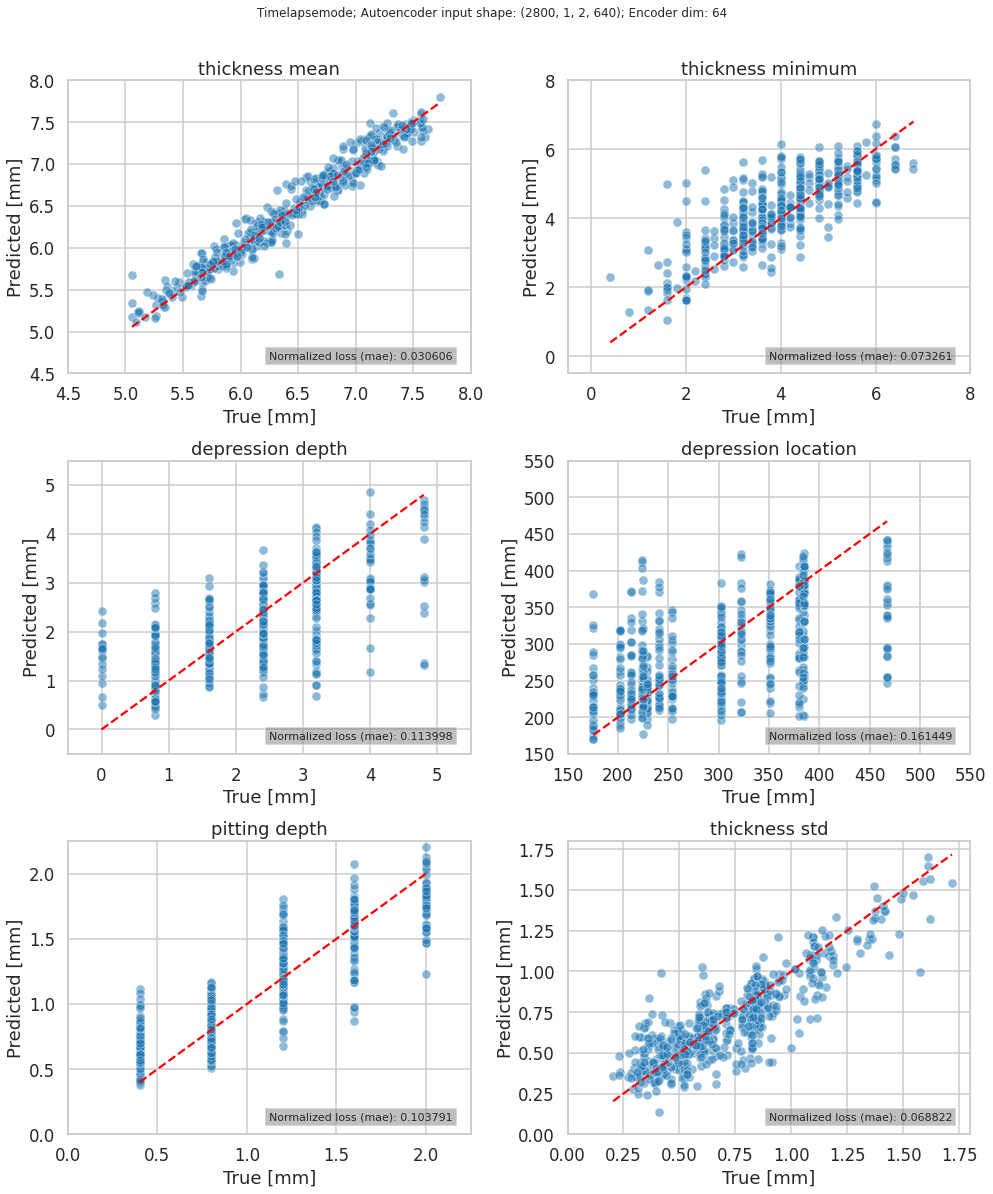

In [95]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False)

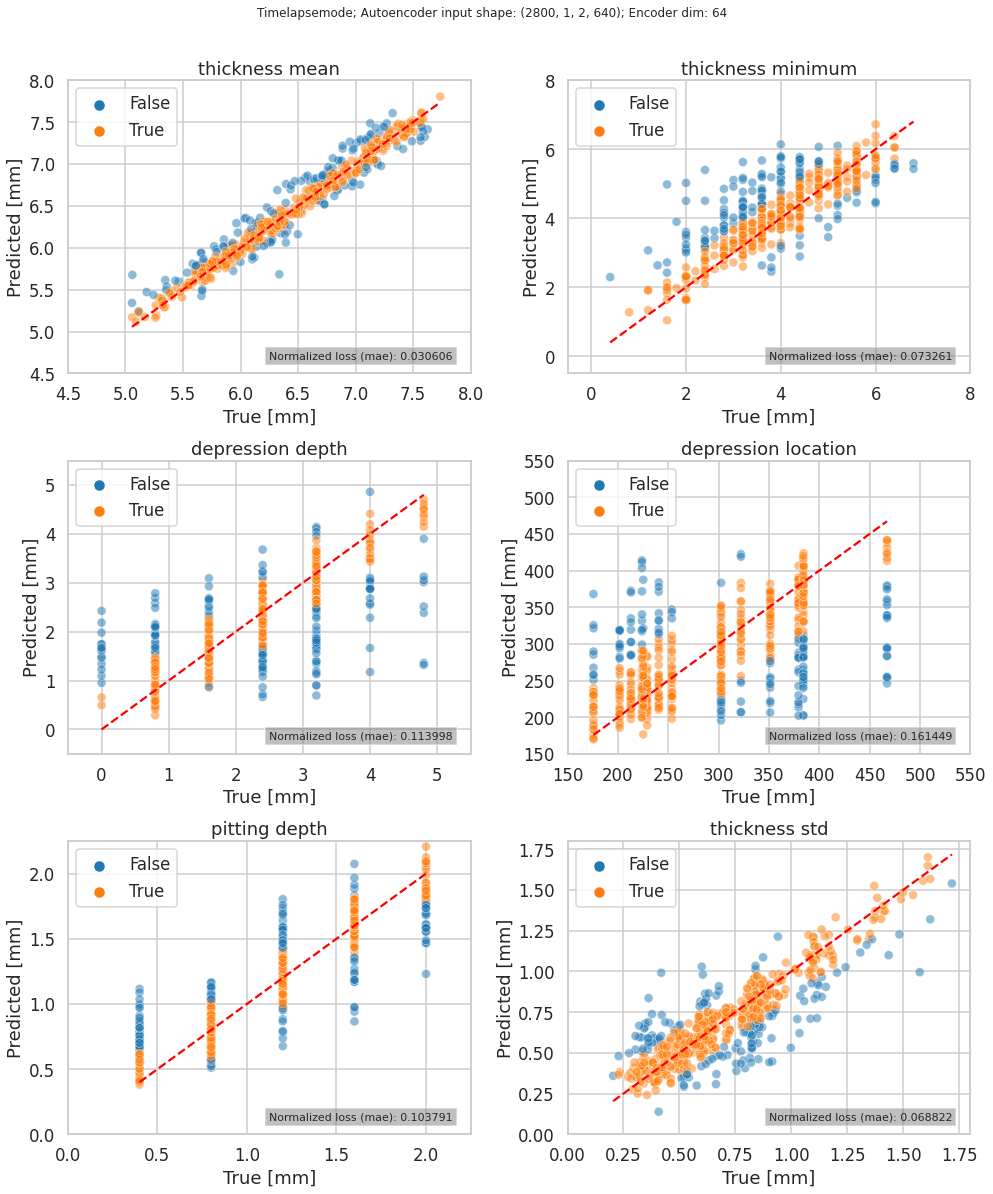

In [96]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=True)

# Extra QC

In [97]:
labels[(labels['pitting depth'] == 10) & (labels['depression depth'] == 24)]

,modelname,thickness,seed,depression depth,pitting depth,depression location,depression width,thickness maximum,thickness minimum,thickness mean,thickness median,thickness std,thickness_var
34,model_t032_s101_d024_p010,32,101,24,10,1756.336829,278.267035,32,1,25.197627,29.0,7.889615,62.246026
69,model_t032_s102_d024_p010,32,102,24,10,1896.793779,320.394762,32,0,24.456308,28.0,8.096513,65.553517
104,model_t032_s103_d024_p010,32,103,24,10,1610.688163,119.686105,32,0,27.888889,30.0,5.863901,34.385335
139,model_t032_s104_d024_p010,32,104,24,10,1119.606839,141.319343,32,0,27.588542,30.0,6.268265,39.291145
174,model_t032_s105_d024_p010,32,105,24,10,1008.702588,183.402517,32,1,26.855903,30.0,6.839619,46.780388
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,model_t040_s112_d024_p010,40,112,24,10,1512.098719,306.121848,40,10,32.537616,36.0,8.102654,65.652999
2694,model_t040_s113_d024_p010,40,113,24,10,2336.230931,79.561440,40,10,36.490451,38.0,4.989821,24.898317
2729,model_t040_s114_d024_p010,40,114,24,10,1126.020039,397.498112,40,6,30.940972,35.0,8.543783,72.996225
2764,model_t040_s115_d024_p010,40,115,24,10,1202.847511,331.109760,40,8,32.075231,36.0,8.228475,67.707797


In [98]:
labels[(labels['seed'] == 104) & (labels['thickness'] == 32)]

,modelname,thickness,seed,depression depth,pitting depth,depression location,depression width,thickness maximum,thickness minimum,thickness mean,thickness median,thickness std,thickness_var
105,model_t032_s104_d000_p002,32,104,0,2,1119.606839,141.319343,32,30,31.043981,31.0,0.725655,0.526574
106,model_t032_s104_d000_p004,32,104,0,4,1119.606839,141.319343,32,28,30.457465,31.0,1.132566,1.282705
107,model_t032_s104_d000_p006,32,104,0,6,1119.606839,141.319343,32,26,30.169271,30.0,1.439768,2.072931
108,model_t032_s104_d000_p008,32,104,0,8,1119.606839,141.319343,32,24,30.047164,30.0,1.626954,2.646979
109,model_t032_s104_d000_p010,32,104,0,10,1119.606839,141.319343,32,22,30.012731,30.0,1.692534,2.864671
110,model_t032_s104_d004_p002,32,104,4,2,1119.606839,141.319343,32,26,30.636285,31.0,1.251085,1.565213
111,model_t032_s104_d004_p004,32,104,4,4,1119.606839,141.319343,32,24,30.046586,30.0,1.544094,2.384226
112,model_t032_s104_d004_p006,32,104,4,6,1119.606839,141.319343,32,22,29.777199,30.0,1.758374,3.091879
113,model_t032_s104_d004_p008,32,104,4,8,1119.606839,141.319343,32,22,29.665509,30.0,1.888293,3.565652
114,model_t032_s104_d004_p010,32,104,4,10,1119.606839,141.319343,32,22,29.631076,30.0,1.938312,3.757054


In [99]:
case_idx = 139

In [100]:
X_case_c = X[case_idx,:,:640]/X.max()
X_case_c = np.expand_dims(X_case_c, 0)
X_case_n = X_case_c + make_noise(-20, X_case_c.shape)
#X_case_n = np.expand_dims(X_case_n, 0)
X_case_n_flat = X_case_n.reshape(1, np.prod(X_case_n.shape))
X_case_decoded = autoencoder.predict(X_case_n_flat)
X_case_decoded_shaped = X_case_decoded.reshape(1, X_case_n.shape[1], X_case_n.shape[2])

ValueError: ignored

In [1]:
X_case_c.shape

NameError: ignored

In [ ]:
#X_case_c.shape, X_case_flat.shape, X_case_decoded_shaped.shape

In [ ]:
X_case_decoded.shape

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.pcolormesh(X_case_n[0,:, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Case input')
#plt.clim([-0.2, 0.2])

plt.subplot(1, 3, 2)
plt.pcolormesh(X_case_decoded_shaped[0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Case decoded')
#plt.clim([-0.2, 0.2])

plt.subplot(1, 3, 3)
plt.pcolormesh(X_case_c[0, :, :].T, cmap='gray', vmin=-1, vmax=1)
plt.gca().invert_yaxis()
plt.grid()
plt.colorbar()
plt.title('Desired output')
#plt.clim([-0.2, 0.2])

plt.show()